In [72]:
# Imports

import torch

from torchtext.data.metrics import bleu_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
# # Mount google drive

# from google.colab import drive
# drive.mount('/content/drive/')

In [74]:
# %cd /content/drive/MyDrive/Colab Notebooks/CSE-676
# %ls

In [75]:
# Helper functions

from helpers.preprocessing import preprocess_data, split_data
from helpers.model_lstm import Encoder, AttentionDecoder
from helpers.training import prepare_dataloader, train
from helpers.evaluation import generate_translation, evaluate

In [76]:
# Global Variables

languages = ['eng', 'fra', 'spa', 'deu', 'por']
LANGUAGE1 = languages[0]
LANGUAGE2 = languages[2]
FILEPATH = f'data/{LANGUAGE1}-{LANGUAGE2}.txt'

# Model tuning parameters

HIDDEN_SIZE = 256
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT = 0.1


losses_list = []  # List to store losses for each language pair
accuracies_list = []  # List to store accuracies for each language pair

Data preprocessing

In [77]:
input_language, output_language, line_pairs = preprocess_data(FILEPATH, LANGUAGE1, LANGUAGE2)

train_pairs, test_pairs = split_data(line_pairs, test_size=0.2)

Number of translation pairs: 9253
spa 4383
eng 2989
Number of training pairs: 7402
Number of testing pairs: 1851


Model

In [78]:
# TODO

# basic, gru, lstm, decoder without attention, diff attension mechanism

In [79]:
encoder = Encoder(input_language.n_words, HIDDEN_SIZE, DROPOUT).to(device)
decoder = AttentionDecoder(HIDDEN_SIZE, output_language.n_words, DROPOUT).to(device)

encoder, decoder

(Encoder(
   (embedding): Embedding(4383, 256)
   (dropout): Dropout(p=0.1, inplace=False)
   (lstm): LSTM(256, 256, batch_first=True)
 ),
 AttentionDecoder(
   (embedding): Embedding(2989, 256)
   (attention): BahdanauAttention(
     (Wa): Linear(in_features=256, out_features=256, bias=True)
     (Ua): Linear(in_features=256, out_features=256, bias=True)
     (Va): Linear(in_features=256, out_features=1, bias=True)
   )
   (lstm): LSTM(512, 256, batch_first=True)
   (out): Linear(in_features=256, out_features=2989, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
 ))

Training

In [80]:
input_language, output_language, train_dataloader = prepare_dataloader(input_language, output_language, train_pairs, BATCH_SIZE)

losses_list, accuracies_list = train(train_dataloader, encoder, decoder, epochs=60, learning_rate=LEARNING_RATE, print_every=5, plot_every=5)


Epoch [5/30], Avg. Loss: 1.7320, Avg. Accuracy: 0.5385
Epoch [10/30], Avg. Loss: 0.6974, Avg. Accuracy: 0.7686
Epoch [15/30], Avg. Loss: 0.2548, Avg. Accuracy: 0.9175
Epoch [20/30], Avg. Loss: 0.0956, Avg. Accuracy: 0.9718
Epoch [25/30], Avg. Loss: 0.0524, Avg. Accuracy: 0.9818
Epoch [30/30], Avg. Loss: 0.0403, Avg. Accuracy: 0.9836


In [81]:
# print( accuracies_list)
# print(losses_list)

In [82]:
print( accuracies_list)
print(losses_list)

[0.3685190870944632, 0.49732883021185137, 0.5624194043598404, 0.6099682734622863, 0.6540783952512537, 0.6915771159553782, 0.7312045849964179, 0.7692764302527889, 0.807123119435063, 0.8436188721727561, 0.8730733804114216, 0.8997850782929075, 0.9224234981066421, 0.9394944222699826, 0.9527376931736772, 0.9619281547436291, 0.9686828369665336, 0.9736567393306724, 0.9765018933578958, 0.9783645481526968, 0.9795926721932249, 0.9816804830621226, 0.9822126701463515, 0.9827857946985978, 0.9824787636884659, 0.9833589192508443, 0.9830314195067035, 0.983706887728994, 0.9838911063350732, 0.9839525125370996]
[2.683449118301786, 1.9014871259187829, 1.5857801072556397, 1.3456894642320172, 1.1437550888493144, 0.9695583296747043, 0.8162718525734441, 0.6792981749207809, 0.5615557176542694, 0.46011891318806286, 0.37389387871170865, 0.303177153049358, 0.24340641755482245, 0.19566529263453236, 0.1580543869399819, 0.12957729681812483, 0.10893897879226454, 0.09069136897872748, 0.07869085560327974, 0.07002164510

Save Model

In [83]:
# Save models

encoder_filepath = f'models/encoder-{LANGUAGE1}-{LANGUAGE2}.pth'
decoder_filepath = f'models/decoder-{LANGUAGE1}-{LANGUAGE2}.pth'

torch.save(encoder.state_dict(), encoder_filepath)
torch.save(decoder.state_dict(), decoder_filepath)

Save Lists

In [85]:
# Save list as a pickle object
import pickle

loss_filename = f'objects/loss_{LANGUAGE2}_{LANGUAGE1}.pkl'
accuracy_filename = f'objects/accuracy_{LANGUAGE2}_{LANGUAGE1}.pkl'

with open(loss_filename, 'wb') as file:
    pickle.dump(losses_list, file)

with open(accuracy_filename, 'wb') as file:
    pickle.dump(losses_list, file)

# Load pickle object back into a list

# with open(loss_filename, 'rb') as file:
#     loss_filename = pickle.load(file)

# with open(accuracy_filename, 'rb') as file:
#     accuracy_filename = pickle.load(file)

# loss_filename, accuracy_filename

Load Model

In [86]:
# Load models

encoder.load_state_dict(torch.load(encoder_filepath))
decoder.load_state_dict(torch.load(decoder_filepath))

<All keys matched successfully>

Evaluation

In [87]:
# Evaluate random training pairs

encoder.eval()
decoder.eval()

references_corpus, candidate_corpus = evaluate(input_language, output_language, encoder, decoder,
                                               train_pairs, evaluate_train=True)

Input Sequence> es beisbolista
Target Sequence = ['he', 's', 'a', 'baseball', 'player']
Predicted sequence < ['he', 's', 'a', 'baseball', 'player']
Input Sequence> no soy quien tu crees
Target Sequence = ['i', 'm', 'not', 'who', 'you', 'think', 'i', 'am']
Predicted sequence < ['i', 'm', 'not', 'who', 'you', 'think', 'i', 'am']
Input Sequence> me voy a morir por congelacion cierra esa ventana
Target Sequence = ['i', 'm', 'freezing', 'to', 'death', 'close', 'that', 'window']
Predicted sequence < ['i', 'm', 'freezing', 'to', 'death', 'close', 'that', 'window']
Input Sequence> llevas los calcetines al reves
Target Sequence = ['you', 're', 'wearing', 'your', 'socks', 'inside', 'out']
Predicted sequence < ['you', 're', 'wearing', 'your', 'socks', 'inside', 'out']
Input Sequence> eres mi enemigo
Target Sequence = ['you', 're', 'my', 'enemy']
Predicted sequence < ['you', 're', 'my', 'enemy']
Input Sequence> el es el hombre adecuado para el puesto
Target Sequence = ['he', 'is', 'the', 'right', 

In [88]:
# Evaluate testing pairs

candidate_corpus, references_corpus = evaluate(input_language, output_language, encoder, decoder,
                                                test_pairs, evaluate_train=False, iterations=len(test_pairs))

Input Sequence> estan bien
Target Sequence = ['they', 're', 'nice']
Predicted sequence < ['they', 're', 'fine']
Input Sequence> aqui todos somos profesores
Target Sequence = ['we', 're', 'all', 'teachers', 'here']
Predicted sequence < ['we', 're', 'here']
Input Sequence> ella esta solo siendo arrogante
Target Sequence = ['she', 's', 'just', 'being', 'snobbish']
Predicted sequence < ['she', 'is', 'just', 'living', 'alone']
Input Sequence> ya no estoy de humor
Target Sequence = ['i', 'm', 'not', 'in', 'the', 'mood', 'anymore']
Predicted sequence < ['i', 'm', 'not', 'in', 'a', 'position', 'to', 'work']
Input Sequence> soy mejor que tom
Target Sequence = ['i', 'm', 'better', 'than', 'tom']
Predicted sequence < ['i', 'm', 'better', 'than', 'tom']
Input Sequence> estan estropeados
Target Sequence = ['they', 're', 'broken']
Predicted sequence < ['they', 're', 'happy']
Input Sequence> estoy aqui para probar que estais equivocados
Target Sequence = ['i', 'm', 'here', 'to', 'prove', 'you', 'wron

Benchmark

In [89]:
bleu = bleu_score(candidate_corpus, references_corpus)

bleu

0.3743093593125583

Analysis

In [90]:
bleu

0.3743093593125583

In [91]:
bleu_score_percentage = bleu * 100
# bleu_score_percentage
print(f"BLEU Score: {bleu_score_percentage:.2f}%")

BLEU Score: 37.43%


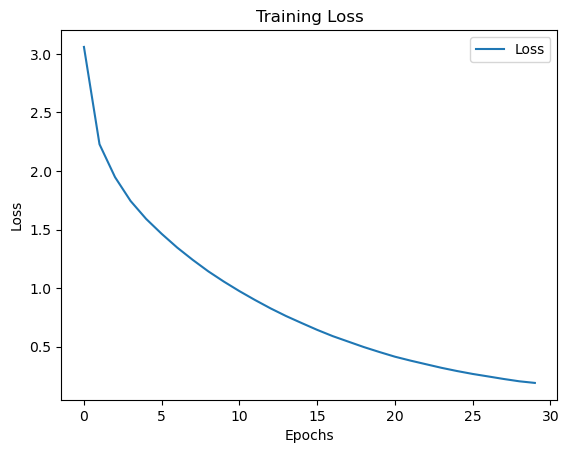

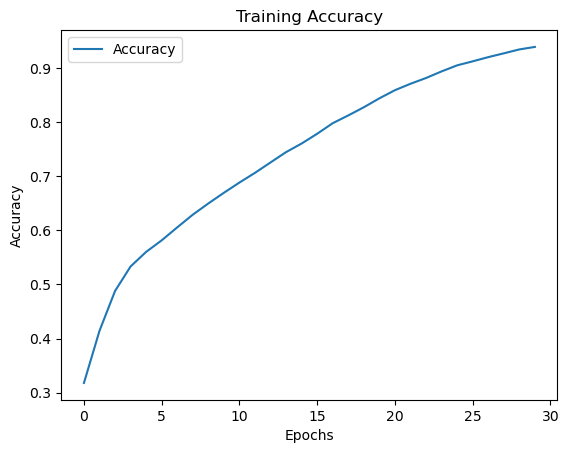

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss for the first language pair
plt.plot(losses_list, label='Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.savefig('training_loss.png')  # Save the loss plot as an image
plt.show()
plt.close()  # Close the plot to start a new one

# Plotting accuracies for the first language pair
plt.plot(accuracies_list, label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.savefig('training_accuracy.png')  # Save the accuracy plot as an image
plt.show()
plt.close()  # Close the plot

# # Display the saved images
# from IPython.display import Image, display
# display(Image(filename='training_loss.png'))
# display(Image(filename='training_accuracy.png'))
